# Hand poses reprojection
Step one find the camera matrix and distortion coefficients.
Step two load images anf corresponding hand poses.
Step three project the hand poses to the image plane.


In [23]:
import torch
import torch.utils
import glob
import numpy as np
import natsort
import cv2 as cv
import matplotlib.pyplot as plt
from numpy.typing import NDArray
import sys
import os
import pandas as pd

fx = 636.6593017578125 
fy = 636.251953125
u_0 = 635.283881879317
v_0 = 366.8740353496978



In [24]:

class TrainDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dir):
        self.dir = dir
        self.frames_paths = natsort.natsorted(glob.glob(f"{dir}framesequences_train/*npy"))
        self.label_list = np.loadtxt(f"{dir}action_labels_train.txt")
        # self.obj_list = np.loadtxt(f"{dir}pose_train.txt")

    def __len__(self):
        return len(self.frames_paths)
    
    def __getitem__(self, idx):
        frames_path = self.frames_paths[idx]
        frames = np.load(frames_path)
        frames = torch.from_numpy(frames).float()
        label = int(self.label_list[idx])
        return frames, label


In [29]:
#convert the action labes adresses to lists 

df : pd.DataFrame = pd.read_csv("/Users/dennisbaumann/3d_vision/data/Dataset/action_train.txt", delimiter=" ")
ids: list[int] = df["id"].to_list()
paths: list[str] = df["path"].to_list()
labels: list[int] = df["action_label"].to_list()
start_acts: list[int] = df["start_act"].to_list()
end_acts: list[int] = df["end_act"].to_list()

print(ids[0])
print(paths[0])
print(labels[0])
print(start_acts[0])
print(end_acts[0])


1
subject1/h1/0
16
0
61


In [36]:
#chrisses code for frames to npy but instead get object poses


def sample_frames(path: str, start_act: int, end_act: int, num_frames: int, base_path) -> NDArray:
    
    sequence_len: int = end_act - start_act
    sample_interval: int = int(sequence_len/(num_frames-1))
    current_frame: int = start_act
    frames_idx: list[int] = []

    #print("start_act: ", start_act, "end_act: ", end_act)
    for i in range(num_frames): 
        frames_idx.append(current_frame)
        current_frame += sample_interval
    #print(frames_idx)
    obj_poses= []
    obj_rt = []
    for i in range(num_frames):
        img_id: str = f"{frames_idx[i]}"
        img_id = img_id.zfill(6)
        obj_path = f"{base_path}{path}/cam4/obj_pose/{img_id}.txt"
        obj_rt_path = f"{base_path}{path}/cam4/obj_pose_rt/{img_id}.txt"
        obj_rt.append(np.loadtxt(obj_rt_path))
        obj_pose = np.loadtxt(obj_path)

        obj_poses.append(obj_pose)
        
    return obj_poses, obj_rt


In [32]:
intrinsics = np.array([[fx, 0, u_0], [0, fy, v_0], [0, 0, 1]])

In [40]:

#extract the object poses for the first sequence
obj_pose, obj_pose_rt = sample_frames(paths[0], start_acts[0], end_acts[0], 32, "/Users/dennisbaumann/3d_vision/data/")
print(len(obj_pose_rt), len(obj_pose_rt[0]))
print(obj_pose_rt[0])   


32 17
[ 8.00000000e+00  2.24740491e-01 -4.59067187e-01  8.59505549e-01
  2.42978663e-02 -3.68907983e-01  7.76326499e-01  5.11101546e-01
 -1.00370545e-02 -9.01885830e-01 -4.31943910e-01  5.11834600e-03
  6.18238386e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00]


In [31]:
train_dataset = TrainDataLoader("/Users/dennisbaumann/3d_vision/data/Dataset/")

torch.Size([2, 32, 256, 455, 3])
tensor(8)


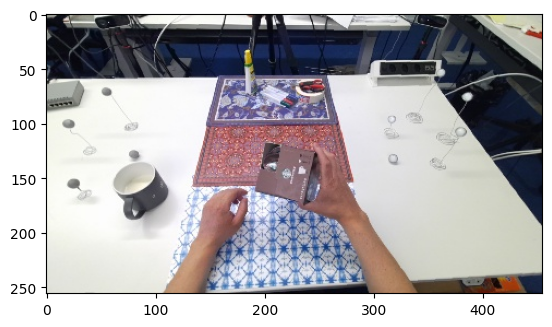

In [14]:
#load and display imaes from the dqtaloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=False)
# Get the first batch of images and labels
images, labels = next(iter(train_loader))

# Convert the first image tensor to a numpy array
image = images[1].numpy()

# If the image has 3 channels, transpose it from (Channels, Height, Width) to (Height, Width, Channels)
if image.shape[0] == 3:
    image = image.transpose((1, 2, 0))

# Display the image
image = image.astype(int)
print(images.shape)
print(labels[1])

plt.imshow(image[31])
plt.show()
